### Zadanie: porównanie metod klasteringu

Zajmiemy zbiorem danych z telefonów Samsung, dotyczących aktywności fizycznej.

Dane są zebrane w pliku Samsung_HAR.zip. Należy je rozpakować i przeanalizować.

Obróbka danych wejściowych:

Czy potrzeba wszystkich cech?

Czy potrzebna jest jakaś obróbka?

Czy wiemy, jak obrobić?

Czy wiemy, co jaka cecha znaczy?

Czy potrzebujemy aż dwóch plików?

Pamiętajmy, że mamy do czynienia z Unsupervised Learning. Czy podział na dane testowe i treningowe jest potrzebny, jeśli tak to dlaczego, jeśli nie to dlaczego?

Do zrobienia:

Użyj poznanych metod klasteringu, aby podzielić dany zbiór (pamiętaj o skalowaniu itp.).

Zwizualizuj podział przez każdy algorytm (możesz użyć metod z notatników).

Z jakim typem czynności algorytmy poradziły sobie super, z jakim nie najlepiej. Typy czynności (dane zawarte w plikach *labels):

1 – marsz

2 – wchodzenie w górę po schodach

3 – schodzenie w dół ze schodów

4 – siedzenie

5 – stanie

6 – leżenie

Dobierz prawidłową ilość klastrów w przypadku metody KMeans.

Na danym zbiorze dokonaj preprocessingu, używając metod klasteringu. Następnie wyszkol dwa wybrane przez siebie klasyfikatory typu Supervised Learning i spróbuj uzyskać jak najlepszy wynik, używając wszystkich znanych sobie "wspomagaczy".

W przypadku użycia train_test_split albo KFold/StratifiedKFold, możemy połączyć zbiory, gdyż i tak wydzielamy zbiór walidacyjny.

Chyba że chcemy mieć dodatkowy zbiór testowy do przetestowania modeli po wyszkoleniu. Chcemy?

Ideą klasteringu jest podział na podgrupy, czyli tutaj oczekujemy, że nasze algorytmy podzielą zbiór na 6 wspomnianych klastrów: marsz, wchodzenie/schodzenie po schodach, siedzenie, stanie, leżenie. Zbadaj, jak są porozrzucane w różnych klastrach. Im bardziej są rozrzucone, tym algorytm gorzej sobie z nimi radzi. Ideałem jest: jeden klaster, jedna czynność.

Na koniec pytanie, na które należy również odpowiedzieć, a które pojawia się zawsze podczas rozmów kwalifikacyjnych:

czym różni się KMeans, K-fold i K Nearest Neighbors (o tym ostatnim trzeba doczytać).
Rozwiązanie prześlij Mentorowi.

### Obróbka danych wejściowych:

Czy potrzeba wszystkich cech? - Nie, tych z bardzo dużymi brakami nie potrzebujemy.

Czy potrzebna jest jakaś obróbka? - Tak, potrzebna jest obróbka danych.

Czy wiemy, jak obrobić? - Tak, muszimy z pliku txt zorbić DF, żeby można je było obrobić. Usunąć należy również kolumny, które mają zbyt mało danych

Czy wiemy, co jaka cecha znaczy? - Nie wiemy, cachy nie mają nagłówków, nie wiemy dlaczego są liczby ujemne.

Czy potrzebujemy aż dwóch plików? - Tak, potrzebujemy dwóch plików train i test, które połączymy, żeby mieć więcej danych.

Pamiętajmy, że mamy do czynienia z Unsupervised Learning. Czy podział na dane testowe i treningowe jest potrzebny, jeśli tak to dlaczego, jeśli nie to dlaczego? - Podział plików na dane testowe i treningowe nie jest potrzebny, ponieważ w Unsupervised Learning nie ma nauczyciela


In [110]:
# manipulacja danymi
import numpy as np
import pandas as pd

# wizualizacja
import matplotlib.pyplot as plt
import seaborn as sns

# podział danych na zbiory treningowe/walidacyjne/testowe
from sklearn.model_selection import train_test_split, GridSearchCV

# budowa Pipeline
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, PowerTransformer

# redukcja wymiarowości
from sklearn.decomposition import PCA

In [111]:
data_train = open('samsung_train.txt')
data_test = open('samsung_test.txt')
linie_train=data_train.readlines()
linie_test=data_test.readlines()

print('liczba wierszy w pliku train={}'.format(len(linie_train)))
print('liczba wierszy w pliku test={}'.format(len(linie_test)))

liczba wierszy w pliku train=7352
liczba wierszy w pliku test=2947


In [112]:
with open('samsung_train.txt') as temp_f:
    col_count = [ len(l.split(" ")) for l in temp_f.readlines() ]

column_names = [i for i in range(max(col_count))] 

data_train = pd.read_csv('samsung_train.txt', sep=' ', header = None, names=column_names )
data_train.head()

,0,1,2,3,4,5,6,7,8,9,...,924,925,926,927,928,929,930,931,932,933
0,NaN,NaN,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [113]:
with open('samsung_test.txt') as temp_f:
    col_count = [ len(l.split(" ")) for l in temp_f.readlines() ]

column_names = [i for i in range(max(col_count))] 

data_test = pd.read_csv('samsung_test.txt', sep=' ', header = None, names=column_names )
data_test.head()

,0,1,2,3,4,5,6,7,8,9,...,790,791,792,793,794,795,796,797,798,799
0,NaN,NaN,0.257178,-0.023285,-0.014654,-0.938404,-0.920091,-0.667683,-0.952501,-0.925249,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,0.286027,-0.013163,-0.119083,-0.975415,-0.967458,-0.944958,-0.986799,-0.968401,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,0.275485,-0.026050,-0.118152,-0.993819,-0.969926,-0.962748,-0.994403,-0.970735,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,0.270298,-0.032614,-0.117520,-0.994743,-0.973268,-0.967091,-0.995274,-0.974471,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,0.274833,-0.027848,-0.129527,-0.993852,-0.967445,-0.978295,-0.994111,-0.965953,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [114]:
data = pd.concat([data_train, data_test])
data.head()

,0,1,2,3,4,5,6,7,8,9,...,924,925,926,927,928,929,930,931,932,933
0,NaN,NaN,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [115]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10299 entries, 0 to 2946
Columns: 934 entries, 0 to 933
dtypes: float64(934)
memory usage: 73.5 MB


<AxesSubplot: >

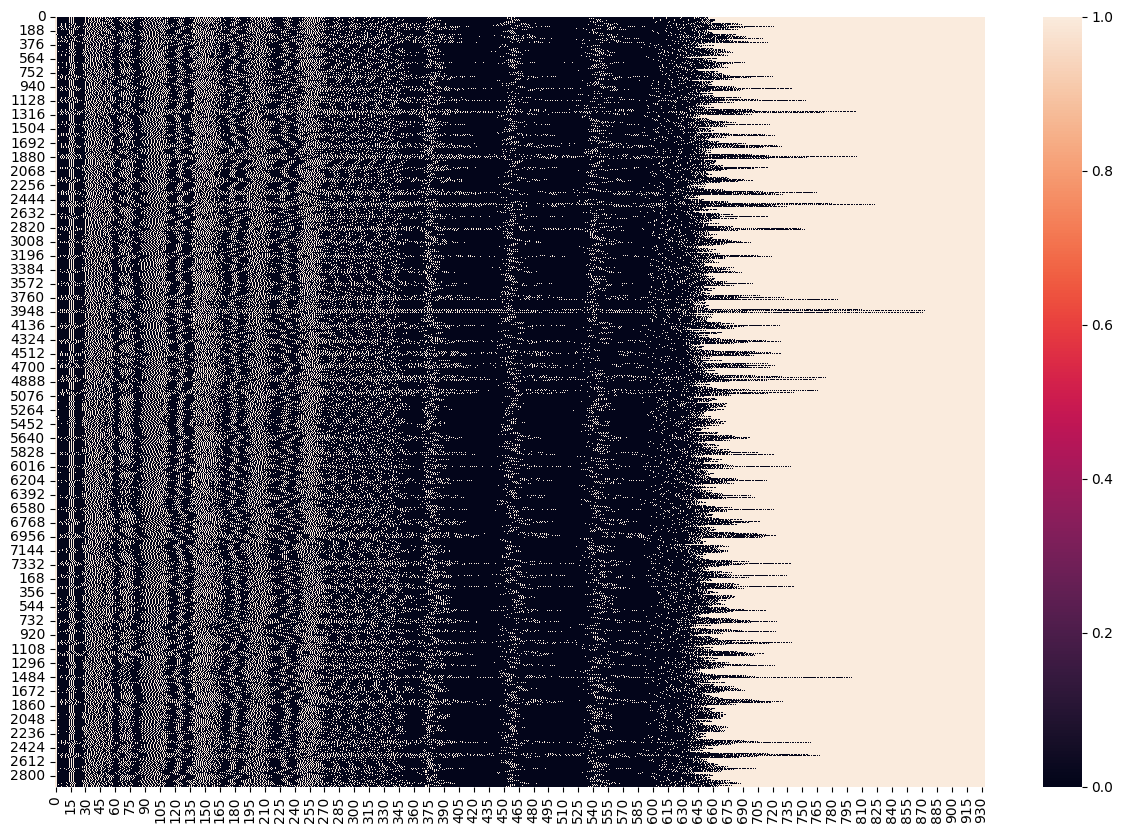

In [116]:
plt.figure(figsize=(15,10))
sns.heatmap(data.isnull())

In [117]:
data.dropna(thresh=10000, axis=1, inplace=True)
data.head()

,2,4,416,417,418,419,420,421,422,423,...,583,584,585,586,587,588,589,590,591,594
0,0.288585,-0.132905,-0.999839,-0.993592,-0.999476,-0.999662,-0.999642,-0.999293,-0.997892,-0.995932,...,-0.999973,-0.999955,-0.999976,-0.999906,-0.999985,-0.999937,-0.999751,-0.999072,-0.999928,-0.999893
1,0.278419,-0.123520,-0.999875,-0.999666,-0.999448,-0.998930,-0.998754,-0.998546,-0.999792,-0.999631,...,-0.999902,-0.999918,-0.999975,-0.999971,-0.999894,-0.999971,-0.980857,-0.975866,-0.975777,-0.980857
2,0.279653,-0.113462,-0.999798,-0.999753,-0.999629,-0.999686,-0.999912,-0.999453,-0.999781,-0.999749,...,-0.999920,-0.999946,-0.999933,-0.999850,-0.999956,-0.987795,-0.989015,-0.985594,-0.993062,-0.999807
3,0.279174,-0.123283,-0.999858,-0.999666,-0.999681,-0.999984,-0.999804,-0.999887,-0.999844,-0.999778,...,-0.999936,-0.999910,-0.999871,-0.999952,-0.987519,-0.986742,-0.983524,-0.990230,-0.998185,-0.983215
4,0.276629,-0.115362,-0.999656,-0.999026,-0.999436,-0.999823,-0.999844,-0.999750,-0.999150,-0.999812,...,-0.999937,-0.999947,-0.999866,-0.999973,-0.993591,-0.990063,-0.992324,-0.990506,-0.987805,-0.997343


In [118]:
data.reset_index(inplace=True)
data.drop(['index'], axis=1, inplace=True)
data.columns = range(data.columns.size)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,77,78,79,80,81,82,83,84,85,86
0,0.288585,-0.132905,-0.999839,-0.993592,-0.999476,-0.999662,-0.999642,-0.999293,-0.997892,-0.995932,...,-0.999973,-0.999955,-0.999976,-0.999906,-0.999985,-0.999937,-0.999751,-0.999072,-0.999928,-0.999893
1,0.278419,-0.123520,-0.999875,-0.999666,-0.999448,-0.998930,-0.998754,-0.998546,-0.999792,-0.999631,...,-0.999902,-0.999918,-0.999975,-0.999971,-0.999894,-0.999971,-0.980857,-0.975866,-0.975777,-0.980857
2,0.279653,-0.113462,-0.999798,-0.999753,-0.999629,-0.999686,-0.999912,-0.999453,-0.999781,-0.999749,...,-0.999920,-0.999946,-0.999933,-0.999850,-0.999956,-0.987795,-0.989015,-0.985594,-0.993062,-0.999807
3,0.279174,-0.123283,-0.999858,-0.999666,-0.999681,-0.999984,-0.999804,-0.999887,-0.999844,-0.999778,...,-0.999936,-0.999910,-0.999871,-0.999952,-0.987519,-0.986742,-0.983524,-0.990230,-0.998185,-0.983215
4,0.276629,-0.115362,-0.999656,-0.999026,-0.999436,-0.999823,-0.999844,-0.999750,-0.999150,-0.999812,...,-0.999937,-0.999947,-0.999866,-0.999973,-0.993591,-0.990063,-0.992324,-0.990506,-0.987805,-0.997343


<AxesSubplot: >

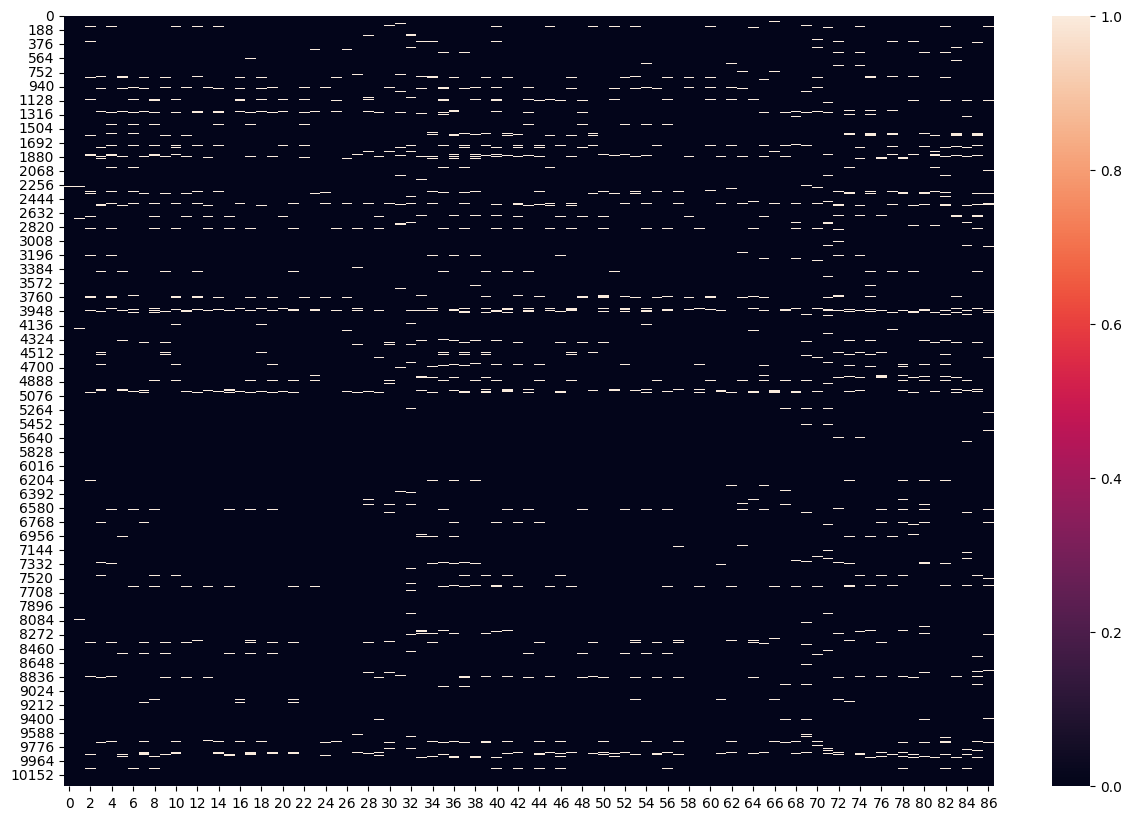

In [119]:
plt.figure(figsize=(15,10))
sns.heatmap(data.isnull())

In [120]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10299 entries, 0 to 10298
Data columns (total 87 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       10279 non-null  float64
 1   1       10227 non-null  float64
 2   2       10010 non-null  float64
 3   3       10022 non-null  float64
 4   4       10045 non-null  float64
 5   5       10057 non-null  float64
 6   6       10066 non-null  float64
 7   7       10066 non-null  float64
 8   8       10084 non-null  float64
 9   9       10098 non-null  float64
 10  10      10117 non-null  float64
 11  11      10129 non-null  float64
 12  12      10148 non-null  float64
 13  13      10120 non-null  float64
 14  14      10156 non-null  float64
 15  15      10147 non-null  float64
 16  16      10161 non-null  float64
 17  17      10153 non-null  float64
 18  18      10189 non-null  float64
 19  19      10181 non-null  float64
 20  20      10181 non-null  float64
 21  21      10180 non-null  float64
 22

In [121]:
from sklearn.cluster import KMeans

In [122]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = data
X = scaler.fit_transform(X)

In [123]:
X_train = data_train
num_features = data.columns

# przygotowanie wartości numerycznych
num_preparation = Pipeline(steps=[
    ('fill_missings', SimpleImputer(strategy='mean')),
    ('scaler_1', StandardScaler()),
    ('pca', PCA(n_components=0.85)),
    ('scaler_2', StandardScaler())])

# transformer = wartości numeryczne oraz kategoryczne
data_preparation = ColumnTransformer(transformers=[
    ('numeric_preprocessing', num_preparation, num_features)])

model_pipeline = Pipeline(steps=[('preprocessor', data_preparation),
                                    ('model', KMeans(n_clusters=6))])
model_pipeline.fit(X_train)

c:\Users\magda\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric_preprocessing',
                                                  Pipeline(steps=[('fill_missings',
                                                                   SimpleImputer()),
                                                                  ('scaler_1',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=0.85)),
                                                                  ('scaler_2',
                                                                   StandardScaler())]),
                                                  RangeIndex(start=0, stop=87, step=1))])),
                ('model', KMeans(n_clusters=6))])

In [124]:
params = {'preprocessor__numeric_preprocessing__fill_missings__strategy': ['mean', 'median'],
'preprocessor__numeric_preprocessing__pca__n_components': [0.85, 0.95, 0.99]}

In [125]:
grid_search = GridSearchCV(model_pipeline, params, scoring='f1_macro')
grid_search.fit(X)
print('Wybrane hiperparametry: ', grid_search.best_params_)
model_kmeans = grid_search.best_estimator_

c:\Users\magda\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\magda\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\magda\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\Users\magda\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' i

Wybrane hiperparametry:  {'preprocessor__numeric_preprocessing__fill_missings__strategy': 'mean', 'preprocessor__numeric_preprocessing__pca__n_components': 0.85}


In [126]:
data.fillna(data_train.mean(), inplace=True)

In [127]:
print(data.isnull())

          0      1      2      3      4      5      6      7      8      9   \
0      False  False  False  False  False  False  False  False  False  False   
1      False  False  False  False  False  False  False  False  False  False   
2      False  False  False  False  False  False  False  False  False  False   
3      False  False  False  False  False  False  False  False  False  False   
4      False  False  False  False  False  False  False  False  False  False   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
10294  False  False  False  False  False  False  False  False  False  False   
10295  False  False  False  False  False  False  False  False  False  False   
10296  False  False  False  False  False  False  False  False  False  False   
10297  False  False  False  False  False  False  False  False  False  False   
10298  False  False  False  False  False  False  False  False  False  False   

       ...     77     78     79     80     81     8

<AxesSubplot: >

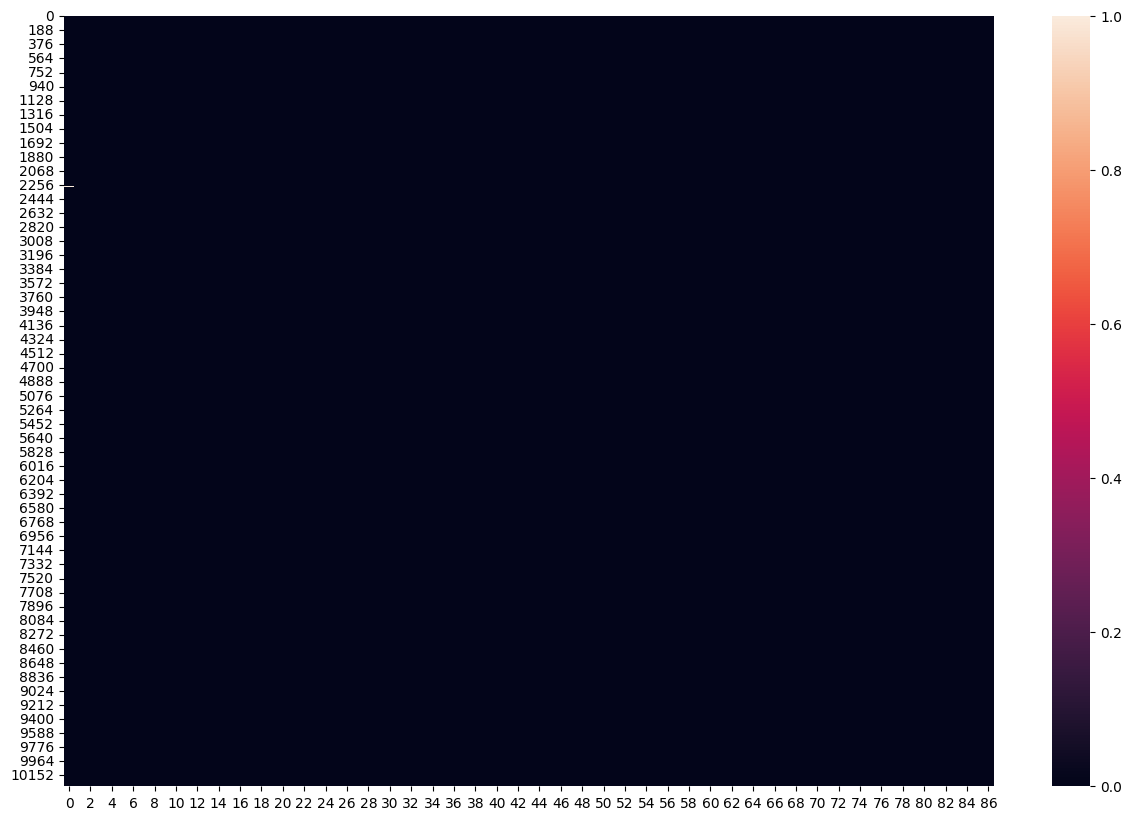

In [128]:
plt.figure(figsize=(15,10))
sns.heatmap(data.isnull())

In [129]:
data.drop(0, axis=1, inplace=True)
data.columns = range(data.columns.size)

In [130]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10299 entries, 0 to 10298
Data columns (total 86 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       10299 non-null  float64
 1   1       10299 non-null  float64
 2   2       10299 non-null  float64
 3   3       10299 non-null  float64
 4   4       10299 non-null  float64
 5   5       10299 non-null  float64
 6   6       10299 non-null  float64
 7   7       10299 non-null  float64
 8   8       10299 non-null  float64
 9   9       10299 non-null  float64
 10  10      10299 non-null  float64
 11  11      10299 non-null  float64
 12  12      10299 non-null  float64
 13  13      10299 non-null  float64
 14  14      10299 non-null  float64
 15  15      10299 non-null  float64
 16  16      10299 non-null  float64
 17  17      10299 non-null  float64
 18  18      10299 non-null  float64
 19  19      10299 non-null  float64
 20  20      10299 non-null  float64
 21  21      10299 non-null  float64
 22

<AxesSubplot: >

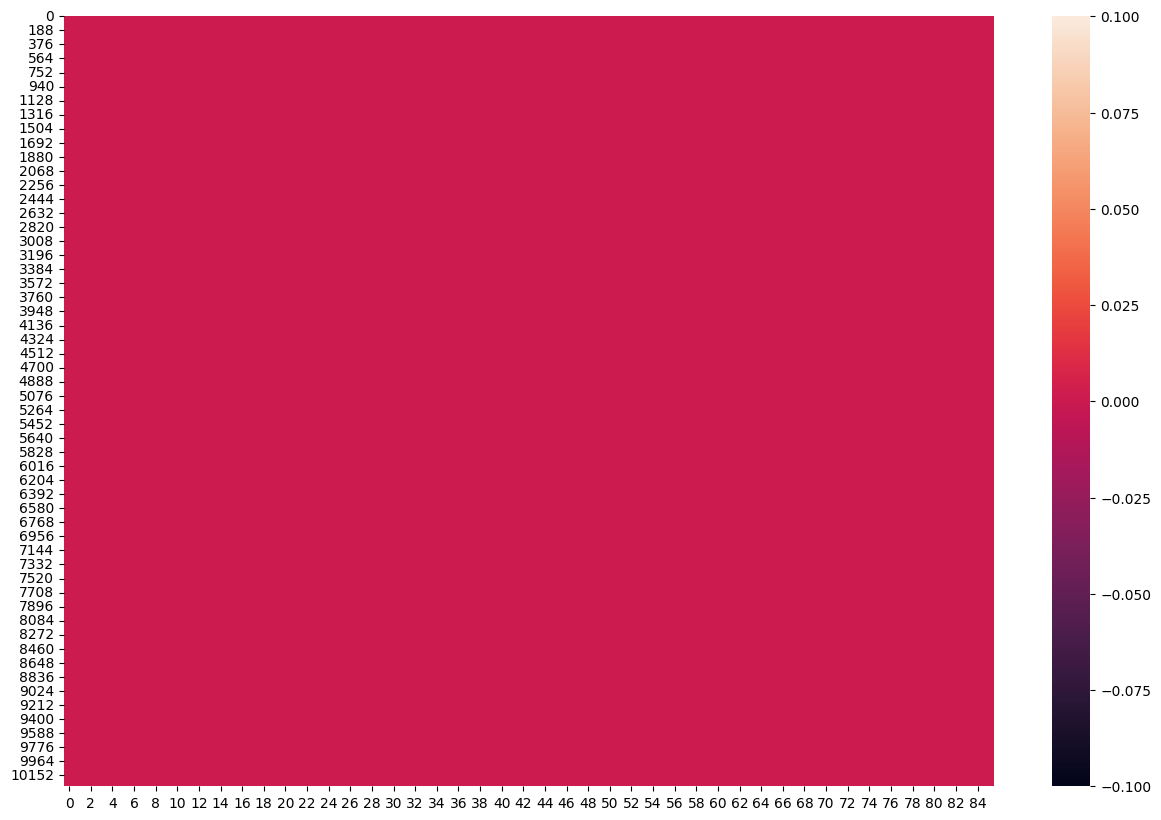

In [136]:
plt.figure(figsize=(15,10))
sns.heatmap(data.isnull())

In [ ]:
import matplotlib.pyplot as plt

X, y, data_classes = iris.data, iris.target, iris.target_names

In [161]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier

In [ ]:
from sklearn.model_selection import cross_val_score, cross_val_predict

# stworzenie klasyfikatora
clf = SGDClassifier(random_state=1)

# użycie metody cross_val_score do sprawdzenia
# działania naszego modelu na różnych podziałach
cv_score = cross_val_score(clf, X, y, cv=5)
print("wynik kroswalidacji: ", cv_score)
print("średni wynik wszystkich foldów: ", cv_score.mean())

In [154]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = data
X = scaler.fit_transform(X)

In [155]:
from sklearn.decomposition import PCA
scaler = PCA(n_components=0.85)
X = scaler.fit_transform(X)

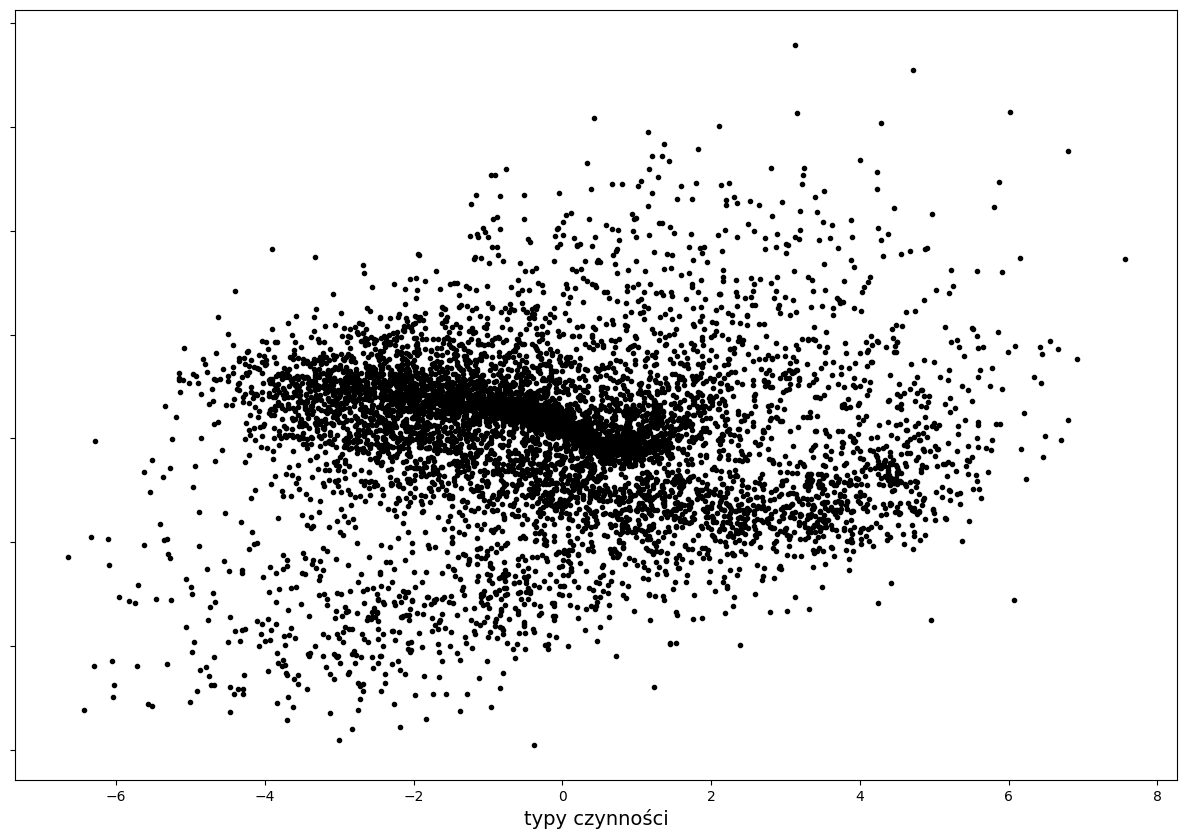

In [156]:
plt.figure(figsize=(15, 10))
plt.subplot()
plt.scatter(X[:, 2], X[:, 3], c="k", marker=".")
plt.xlabel("typy czynności", fontsize=14)
plt.tick_params(labelleft=False)

plt.show()

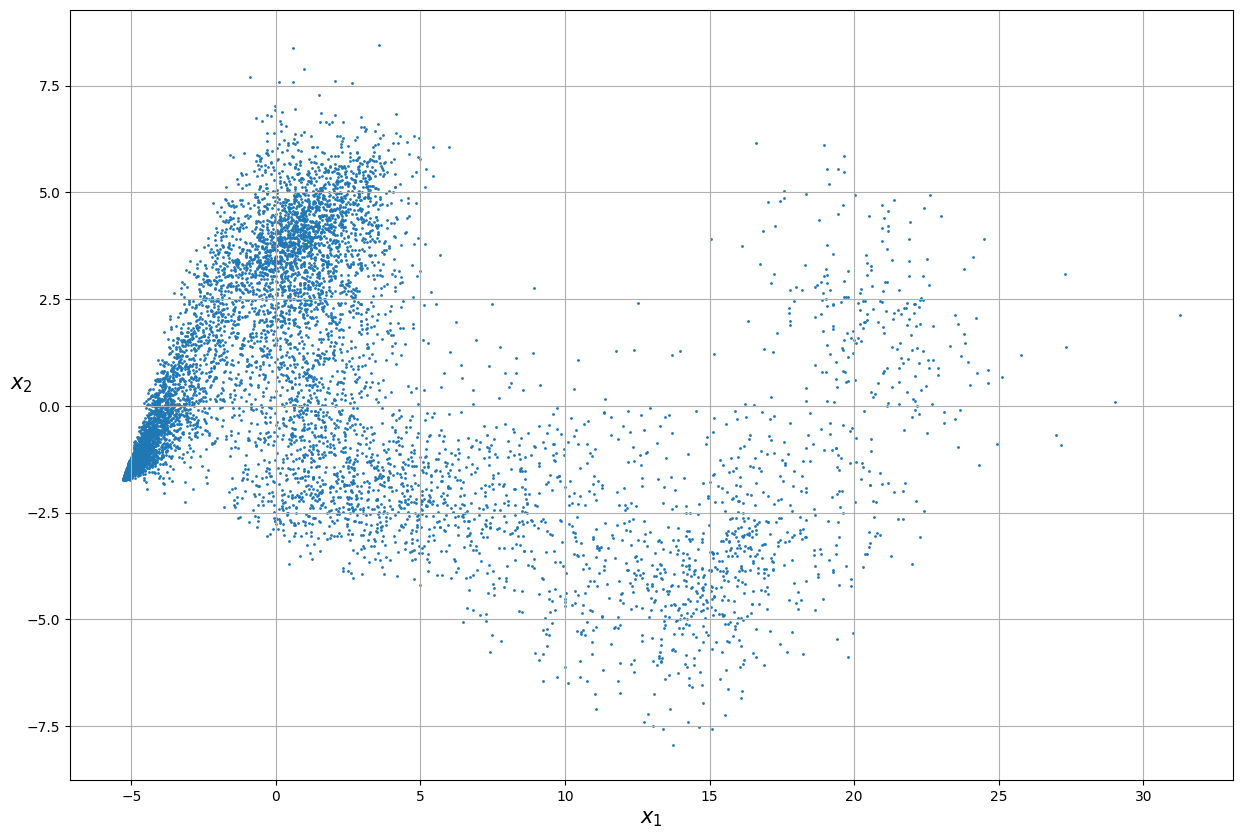

In [157]:
def plot_clusters(X, y=None):
    plt.figure(figsize=(15, 10))
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=15)
    plt.ylabel("$x_2$", fontsize=15, rotation=0)
    plt.grid()

plot_clusters(X)

In [158]:
# import odpowiedniej biblioteki
from sklearn.cluster import KMeans

clf = KMeans(n_clusters=6)

# możemy uzyć metod fit(), predict() 
clf.fit(X)
y_pred = clf.predict(X)

#albo metody fit/predict, która łączy dwie powyższe

y_pred = clf.fit_predict(X)
print(y_pred)

c:\Users\magda\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\magda\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[1 1 1 ... 3 3 3]


In [159]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=3, linewidths=8,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(klasyfikator, X):
    # wyznaczanie granic decyzyjnych, podobnie jak w poprzednich notatnikach
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], 100),
                         np.linspace(mins[1], maxs[1], 100))
    Z = klasyfikator.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # rysowanie konturów granic 
    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    
    # rysowanie danych
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    # centra klastrów można wyciągnąc za pomocą zmiennej cluster_centers_
    plot_centroids(klasyfikator.cluster_centers_)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

In [160]:
plt.figure(figsize=(10, 5))
plot_decision_boundaries(clf, X)
plt.show()

ValueError: X has 2 features, but KMeans is expecting 32 features as input.

<Figure size 1000x500 with 0 Axes>

In [151]:
clf.cluster_centers_

array([[-8.76736387e-02, -5.19255771e-01, -5.42678918e-01,
        -5.43557400e-01, -5.42213167e-01, -5.45787947e-01,
        -5.47428313e-01, -5.38576256e-01, -5.40002940e-01,
        -5.28940155e-01, -5.19510566e-01, -5.14439184e-01,
        -5.11554805e-01, -4.90000719e-01, -4.58288393e-01,
        -4.75590329e-01, -4.64178088e-01, -4.82978779e-01,
        -4.76673478e-01, -5.13766125e-01, -5.42415553e-01,
        -5.50646380e-01, -5.77167817e-01, -5.95726480e-01,
        -6.24967122e-01, -6.39850795e-01, -6.69985279e-01,
        -6.96973612e-01, -7.23286856e-01, -7.25835953e-01,
        -6.92695844e-01, -6.32232707e-01, -5.37453573e-01,
        -5.25800895e-01, -5.27594446e-01, -5.27834213e-01,
        -5.25773412e-01, -5.28659470e-01, -5.28831093e-01,
        -5.28138627e-01, -5.26536862e-01, -5.31988845e-01,
        -5.28876075e-01, -5.24866717e-01, -5.27963101e-01,
        -5.18495548e-01, -5.10730019e-01, -5.03044437e-01,
        -4.95573613e-01, -4.82049127e-01, -4.72231997e-0

In [152]:
# poszczególne kroki 

clf_1 = KMeans(n_clusters=5, max_iter=1, init="random", n_init=1, algorithm="lloyd", random_state=42)
clf_2 = KMeans(n_clusters=5, max_iter=2, init="random", n_init=1, algorithm="lloyd", random_state=42)
clf_3 = KMeans(n_clusters=5, max_iter=3, init="random", n_init=1, algorithm="lloyd", random_state=42)
clf_300 = KMeans(n_clusters=5, max_iter=300, init="random", n_init=1, algorithm="lloyd", random_state=42)
clf_1.fit(X)
clf_2.fit(X)
clf_3.fit(X)
clf_300.fit(X)

KMeans(init='random', n_clusters=5, n_init=1, random_state=42)

ValueError: X has 2 features, but KMeans is expecting 86 features as input.

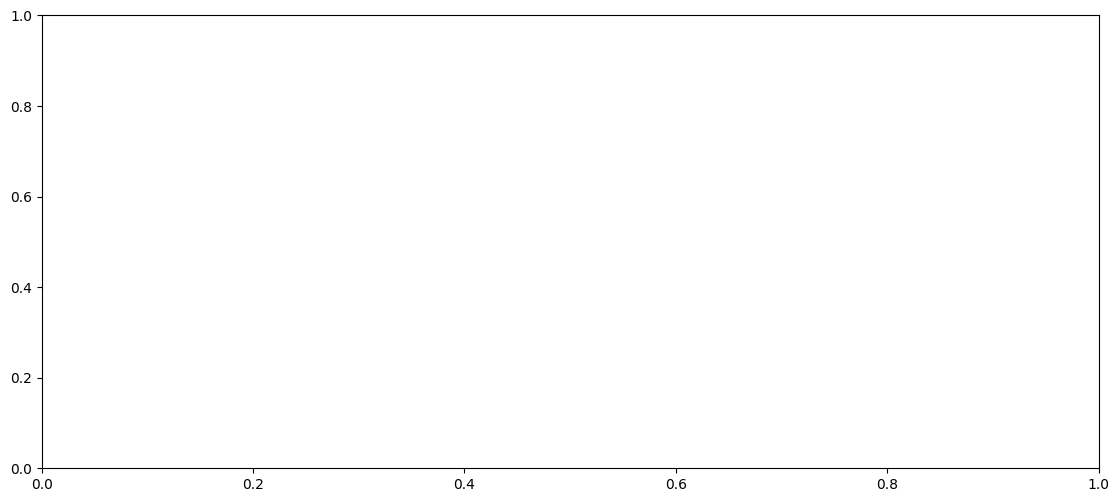

In [153]:
# narysujmy teraz poszczególne kroki jeden pod drugim

plt.figure(figsize=(30, 20))

plt.subplot(321)
plot_decision_boundaries(clf_1, X)

plt.subplot(322)
plot_decision_boundaries(clf_2, X)

plt.subplot(323)
plot_decision_boundaries(clf_3, X)

plt.subplot(324)
plot_decision_boundaries(clf_300, X)
plt.show()

In [162]:
labels_train = open('samsung_train_labels.txt')
labels_test = open('samsung_test_labels.txt')
linie_train=labels_train.readlines()
linie_test=labels_test.readlines()

print('liczba wierszy w pliku train={}'.format(len(linie_train)))
print('liczba wierszy w pliku test={}'.format(len(linie_test)))

liczba wierszy w pliku train=7352
liczba wierszy w pliku test=2947


In [163]:
labels_train = pd.read_csv('samsung_train_labels.txt', header = None)
labels_train.head()

,0
0,5
1,5
2,5
3,5
4,5


In [164]:
labels_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       7352 non-null   int64
dtypes: int64(1)
memory usage: 57.6 KB


In [165]:
labels_test = pd.read_csv('samsung_test_labels.txt', header = None)
labels_test.head()

,0
0,5
1,5
2,5
3,5
4,5


In [166]:
labels_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2947 entries, 0 to 2946
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       2947 non-null   int64
dtypes: int64(1)
memory usage: 23.1 KB


In [167]:
labels_train.columns = ['target']
labels_test.columns = ['target']
target = pd.concat([labels_train, labels_test])
target.head()

,target
0,5
1,5
2,5
3,5
4,5


In [168]:
target.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10299 entries, 0 to 2946
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   target  10299 non-null  int64
dtypes: int64(1)
memory usage: 160.9 KB


In [169]:
target.reset_index(inplace=True)
target.drop(['index'], axis=1, inplace=True)
target.head()

,target
0,5
1,5
2,5
3,5
4,5


In [170]:
dataset=pd.concat([data, target], axis=1)
dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,77,78,79,80,81,82,83,84,85,target
0,-0.132905,-0.999839,-0.993592,-0.999476,-0.999662,-0.999642,-0.999293,-0.997892,-0.995932,-0.995146,...,-0.999955,-0.999976,-0.999906,-0.999985,-0.999937,-0.999751,-0.999072,-0.999928,-0.999893,5
1,-0.123520,-0.999875,-0.999666,-0.999448,-0.998930,-0.998754,-0.998546,-0.999792,-0.999631,-0.998878,...,-0.999918,-0.999975,-0.999971,-0.999894,-0.999971,-0.980857,-0.975866,-0.975777,-0.980857,5
2,-0.113462,-0.999798,-0.999753,-0.999629,-0.999686,-0.999912,-0.999453,-0.999781,-0.999749,-0.999760,...,-0.999946,-0.999933,-0.999850,-0.999956,-0.987795,-0.989015,-0.985594,-0.993062,-0.999807,5
3,-0.123283,-0.999858,-0.999666,-0.999681,-0.999984,-0.999804,-0.999887,-0.999844,-0.999778,-0.999792,...,-0.999910,-0.999871,-0.999952,-0.987519,-0.986742,-0.983524,-0.990230,-0.998185,-0.983215,5
4,-0.115362,-0.999656,-0.999026,-0.999436,-0.999823,-0.999844,-0.999750,-0.999150,-0.999812,-0.999793,...,-0.999947,-0.999866,-0.999973,-0.993591,-0.990063,-0.992324,-0.990506,-0.987805,-0.997343,5


In [ ]:
# dataset.columns = range(dataset.columns.size)
# dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,913,914,915,916,917,918,919,920,921,922
0,NaN,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
1,NaN,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
2,NaN,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
3,NaN,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
4,NaN,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5


<AxesSubplot: >

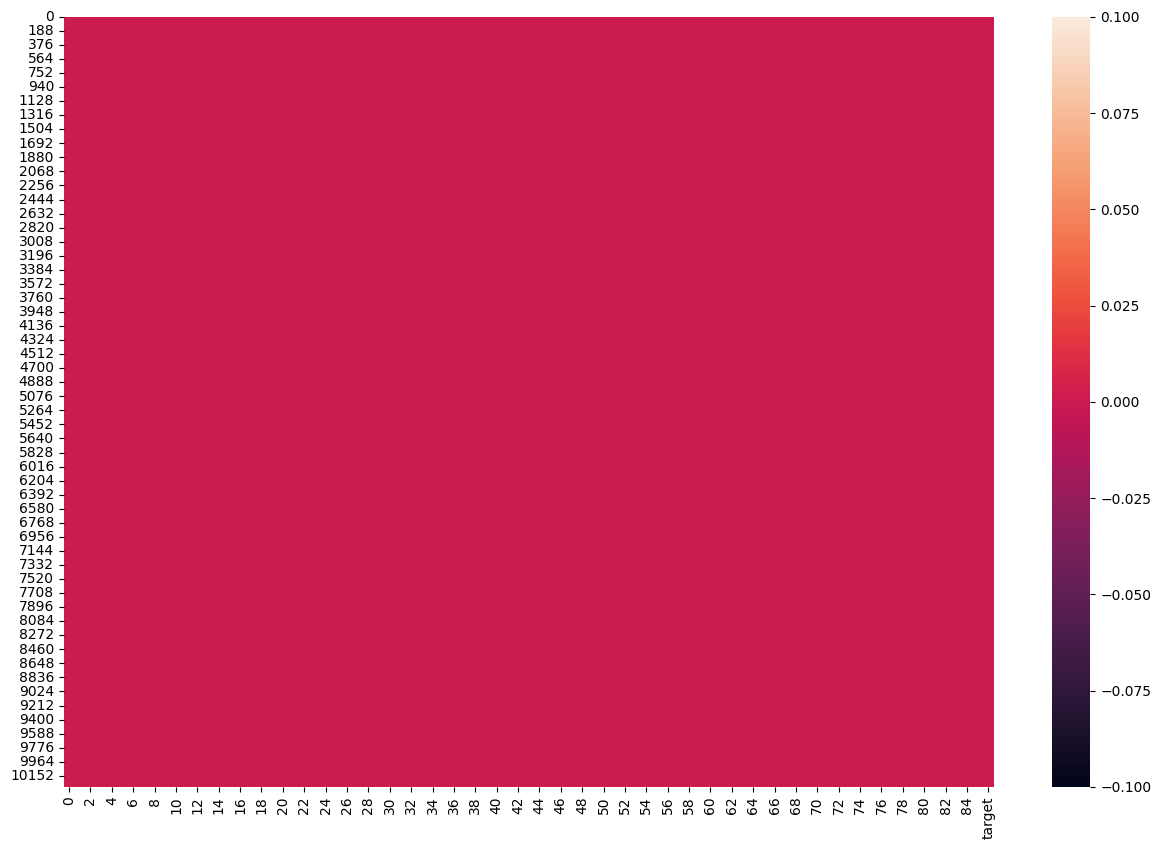

In [171]:
plt.figure(figsize=(15,10))
sns.heatmap(dataset.isnull())

In [172]:
# dataset.fillna(0, inplace=True)

In [173]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10299 entries, 0 to 10298
Data columns (total 87 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       10299 non-null  float64
 1   1       10299 non-null  float64
 2   2       10299 non-null  float64
 3   3       10299 non-null  float64
 4   4       10299 non-null  float64
 5   5       10299 non-null  float64
 6   6       10299 non-null  float64
 7   7       10299 non-null  float64
 8   8       10299 non-null  float64
 9   9       10299 non-null  float64
 10  10      10299 non-null  float64
 11  11      10299 non-null  float64
 12  12      10299 non-null  float64
 13  13      10299 non-null  float64
 14  14      10299 non-null  float64
 15  15      10299 non-null  float64
 16  16      10299 non-null  float64
 17  17      10299 non-null  float64
 18  18      10299 non-null  float64
 19  19      10299 non-null  float64
 20  20      10299 non-null  float64
 21  21      10299 non-null  float64
 22

In [175]:
from pandas import RangeIndex

features = RangeIndex(start=0, stop=86, step=1)
# target = 86
X, y = dataset[features], dataset['target']
print('X:')
display(X)
print('\ny:')
display(y)

X:


,0,1,2,3,4,5,6,7,8,9,...,76,77,78,79,80,81,82,83,84,85
0,-0.132905,-0.999839,-0.993592,-0.999476,-0.999662,-0.999642,-0.999293,-0.997892,-0.995932,-0.995146,...,-0.999973,-0.999955,-0.999976,-0.999906,-0.999985,-0.999937,-0.999751,-0.999072,-0.999928,-0.999893
1,-0.123520,-0.999875,-0.999666,-0.999448,-0.998930,-0.998754,-0.998546,-0.999792,-0.999631,-0.998878,...,-0.999902,-0.999918,-0.999975,-0.999971,-0.999894,-0.999971,-0.980857,-0.975866,-0.975777,-0.980857
2,-0.113462,-0.999798,-0.999753,-0.999629,-0.999686,-0.999912,-0.999453,-0.999781,-0.999749,-0.999760,...,-0.999920,-0.999946,-0.999933,-0.999850,-0.999956,-0.987795,-0.989015,-0.985594,-0.993062,-0.999807
3,-0.123283,-0.999858,-0.999666,-0.999681,-0.999984,-0.999804,-0.999887,-0.999844,-0.999778,-0.999792,...,-0.999936,-0.999910,-0.999871,-0.999952,-0.987519,-0.986742,-0.983524,-0.990230,-0.998185,-0.983215
4,-0.115362,-0.999656,-0.999026,-0.999436,-0.999823,-0.999844,-0.999750,-0.999150,-0.999812,-0.999793,...,-0.999937,-0.999947,-0.999866,-0.999973,-0.993591,-0.990063,-0.992324,-0.990506,-0.987805,-0.997343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10294,-0.099109,-0.917319,-0.624293,-0.905242,-0.708900,-0.788286,-0.883416,-0.947561,-0.953597,-0.955278,...,-0.989915,-0.881335,-0.963488,-0.736029,-0.933940,-0.968346,-0.985828,-0.969920,-0.955867,-0.726733
10295,-0.105915,-0.862534,-0.685810,-0.830733,-0.834158,-0.945399,-0.966117,-0.941307,-0.910753,-0.954239,...,-0.643173,-0.929016,-0.934579,-0.979089,-0.983313,-0.948814,-0.963732,-0.958773,-0.636741,-0.961576
10296,0.030077,-0.887513,-0.735537,-0.828125,-0.882700,-0.940960,-0.936198,-0.841898,-0.684932,-0.611587,...,-0.898842,-0.956896,-0.700468,-0.911621,-0.947430,-0.965275,-0.955238,-0.935877,-0.906922,-0.933064
10297,0.018467,-0.695248,-0.952252,-0.721997,-0.751269,-0.887577,-0.913464,-0.934604,-0.929265,-0.900130,...,-0.971129,-0.801332,-0.943289,-0.958771,-0.957152,-0.941656,-0.919191,-0.862114,-0.801197,-0.935400



y:


0        5
1        5
2        5
3        5
4        5
        ..
10294    2
10295    2
10296    2
10297    2
10298    2
Name: target, Length: 10299, dtype: int64

In [176]:
pd.Series(y).value_counts(normalize=True)

6    0.188756
5    0.185067
4    0.172541
1    0.167201
2    0.149917
3    0.136518
Name: target, dtype: float64

In [177]:
from scipy import stats

corr_dict = {}
for col in features:
    corr_dict[col] = stats.pointbiserialr(X[col], y)[0]
pd.Series(corr_dict).sort_values(ascending=False)

0    -0.078431
85   -0.099239
84   -0.155204
83   -0.182715
82   -0.204620
        ...   
28   -0.519610
27   -0.531488
25   -0.532549
24   -0.534270
26   -0.541538
Length: 86, dtype: float64

In [178]:
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier

In [179]:
from sklearn.model_selection import cross_val_score, cross_val_predict

# stworzenie klasyfikatora
clf = SGDClassifier(random_state=1)

# użycie metody cross_val_score do sprawdzenia
# działania naszego modelu na różnych podziałach
cv_score = cross_val_score(clf, X, y, cv=5)
print("wynik kroswalidacji: ", cv_score)
print("średni wynik wszystkich foldów: ", cv_score.mean())

wynik kroswalidacji:  [0.45679612 0.41213592 0.37961165 0.45631068 0.42933463]
średni wynik wszystkich foldów:  0.4268377994784913


In [184]:
#Przykład podziału za pomocą stratyfikacji
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, 
                                    random_state=3, stratify=y)
# summarize
train_1, train_2, train_3, train_4, train_5, train_6 = len(y_train[y_train==1]), len(y_train[y_train==2]), len(y_train[y_train==3]), len(y_train[y_train==4]), len(y_train[y_train==5]), len(y_train[y_train==6])
test_1, test_2, test_3, test_4, test_5, test_6 = len(y_test[y_test==1]), len(y_test[y_test==2]), len(y_test[y_test==3]), len(y_test[y_test==4]), len(y_test[y_test==5]), len(y_test[y_test==6])

print('>Train: 1=%d, 2=%d, 3=%d, 4=%d,5=%d, 6=%d, Test: 1=%d, 2=%d, 3=%d, 4=%d,5=%d, 6=%d' % (train_1, train_2, train_3, train_4, train_5, train_6, test_1, test_2, test_3, test_4, test_5, test_6))

>Train: 1=1378, 2=1235, 3=1125, 4=1421,5=1525, 6=1555, Test: 1=344, 2=309, 3=281, 4=356,5=381, 6=389


InvalidIndexError: (0        False
1        False
2        False
3        False
4        False
         ...  
10294    False
10295    False
10296    False
10297    False
10298    False
Name: target, Length: 10299, dtype: bool, 1)

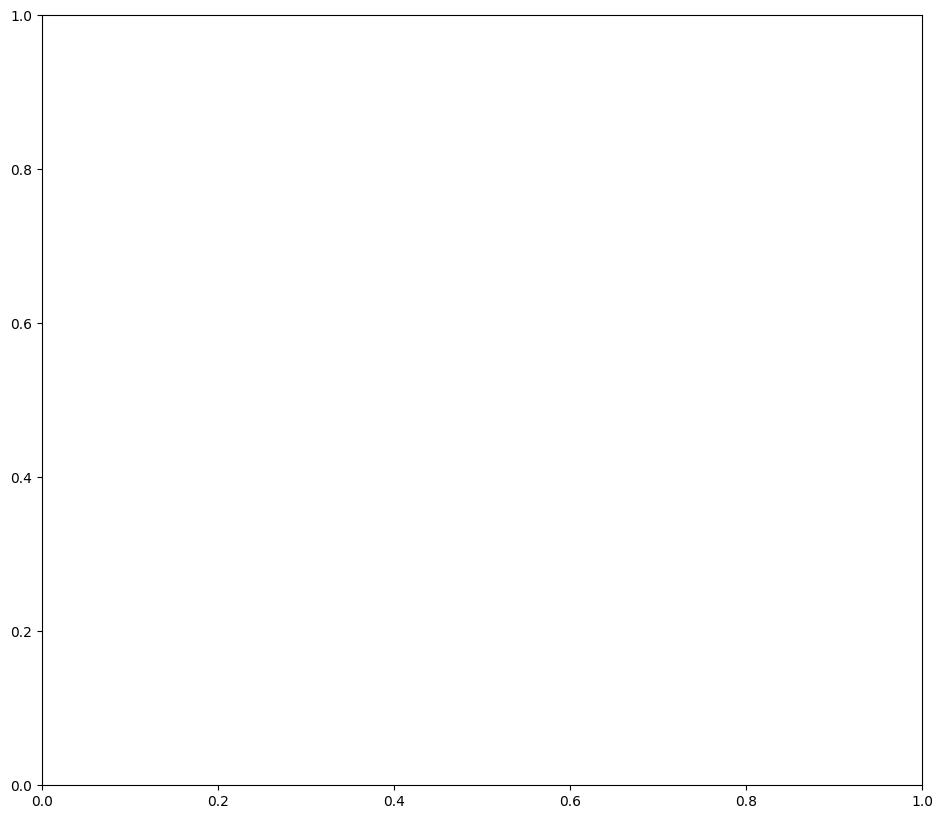

In [193]:
# przykład podziału dancyh w przypadku Supervised Learning oraz Clusteringu

plt.figure(figsize=(25, 10))

plt.subplot(121)
plt.plot(X[y==1, 1], X[y==1, 10299], "yo", label="class 1")
plt.plot(X[y==2, 1], X[y==2, 10299], "bs", label="class 2")
plt.plot(X[y==3, 1], X[y==3, 10299], "g^", label="class 3")
plt.plot(X[y==4, 1], X[y==4, 10299], "yo", label="class 4")
plt.plot(X[y==5, 1], X[y==5, 10299], "bs", label="class 5")
plt.plot(X[y==6, 1], X[y==6, 10299], "g^", label="class 6")

plt.xlabel("dane", fontsize=14)
plt.ylabel("typy czynności", fontsize=14)
plt.legend(fontsize=12)

plt.subplot(122)
plt.scatter(X[:, 2], X[:, 3], c="k", marker=".")
plt.xlabel("dane", fontsize=14)
plt.tick_params(labelleft=False)

plt.show()